In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_selection import SelectKBest, chi2

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, GRU, Dense, Dropout, Bidirectional, Conv1D, GlobalMaxPooling1D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


C:\Users\Primadya\AppData\Local\Temp\ipykernel_18548\3456542538.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
df = pd.read_csv('dataset_resampled_baru_pol.csv')
df.head()

,ulasan,ulasan_bersih,sentimen_score,sentimen
0,bagus sih GK nyesel kalo download ny tp kadang...,bagu sih gk nyesel kalo download ny tp kadang ...,0,neutral
1,Aplikasi nya bagus banget buat edit foto atau ...,aplikasi nya bagu banget buat edit foto atau m...,6,positive
2,please! kembalikan B612 seperti dulu lagi yg s...,pleas kembalikan b seperti dulu lagi yg sllu b...,-16,negative
3,"Sejak di update semakin banyak pro,ada iklan g...",sejak di updat semakin banyak proada iklan ga ...,-3,negative
4,Aku sukaaa bgt sama B612... filter nya bikin m...,aku sukaaa bgt sama b filter nya bikin muka ja...,2,positive


In [3]:
# Menghapus feature yang tidak diperlukan
df.drop(['ulasan', 'sentimen_score'], axis=1, inplace=True)
df.head()

,ulasan_bersih,sentimen
0,bagu sih gk nyesel kalo download ny tp kadang ...,neutral
1,aplikasi nya bagu banget buat edit foto atau m...,positive
2,pleas kembalikan b seperti dulu lagi yg sllu b...,negative
3,sejak di updat semakin banyak proada iklan ga ...,negative
4,aku sukaaa bgt sama b filter nya bikin muka ja...,positive


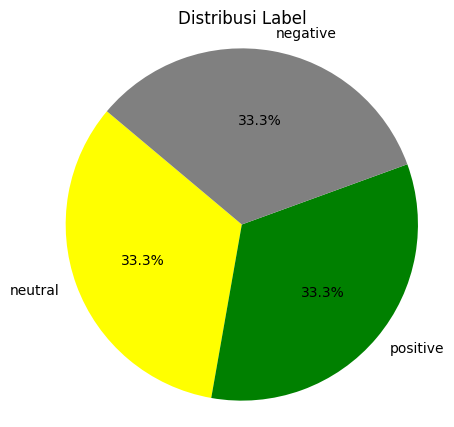

sentimen
neutral     9712
positive    9712
negative    9712
Name: count, dtype: int64


In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Tampilkan distribusi label
label_counts = df['sentimen'].value_counts()
plt.figure(figsize=(5, 5), facecolor='white')

# Ubah warna plot menjadi kuning, hijau, dan abu-abu
colors = ['yellow', 'green', 'gray']
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=140, colors=colors)
plt.title('Distribusi Label')
plt.axis('equal')
plt.show()

print(label_counts)

In [5]:
# Hitung jumlah total data
total_data = len(df)

# Tampilkan hasil
print(f"Jumlah total data: {total_data}")

Jumlah total data: 29136


In [6]:
X = df['ulasan_bersih'].values
y = df['sentimen'].values

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [8]:
# Tokenisasi
X_train_text = [' '.join(X.split()) for X in X_train]
X_test_text = [' '.join(X.split()) for X in X_test]

In [9]:
# Tokenisasi dan padding
vocab_size = 5000
embedding_dim = 16
max_len = 200

tokenizer = Tokenizer(num_words=vocab_size, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post')

X_test_seq = tokenizer.texts_to_sequences(X_test)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post')

# Merubah label yang dari str menjadi int
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

In [10]:
# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [11]:
# Definisi model CNN
model_cnn = Sequential([
    Embedding(vocab_size, embedding_dim, input_length=max_len),
    Conv1D(128, 5, activation='relu'),
    GlobalMaxPooling1D(),
    Dense(128, activation='relu'),
    Dense(len(label_encoder.classes_), activation='softmax')
])

d:\Aplikasi\miniconda3\envs\envq\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [12]:
# Compile the model
model_cnn.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


In [13]:
# Latih model
history = model_cnn.fit(
    X_train_pad, y_train_encoded,
    validation_data=(X_test_pad, y_test_encoded),
    epochs=20,  # Anda bisa mengubah jumlah epoch sesuai kebutuhan
    batch_size=32,
    callbacks=[early_stopping]
)


Epoch 1/20
729/729 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.6286 - loss: 0.7470 - val_accuracy: 0.9202 - val_loss: 0.2529
Epoch 2/20
729/729 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9483 - loss: 0.1586 - val_accuracy: 0.9485 - val_loss: 0.1561
Epoch 3/20
729/729 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9818 - loss: 0.0615 - val_accuracy: 0.9561 - val_loss: 0.1313
Epoch 4/20
729/729 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9933 - loss: 0.0260 - val_accuracy: 0.9592 - val_loss: 0.1459
Epoch 5/20
729/729 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9955 - loss: 0.0154 - val_accuracy: 0.9650 - val_loss: 0.1381
Epoch 6/20
729/729 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9969 - loss: 0.0098 - val_accuracy: 0.9528 - val_loss: 0.2119


In [14]:
# Evaluasi model
results = model_cnn.evaluate(X_test_pad, y_test_encoded)
print(results)

183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9571 - loss: 0.1290
[0.13125361502170563, 0.9560741186141968]


# Grafik LSTM dan CNN

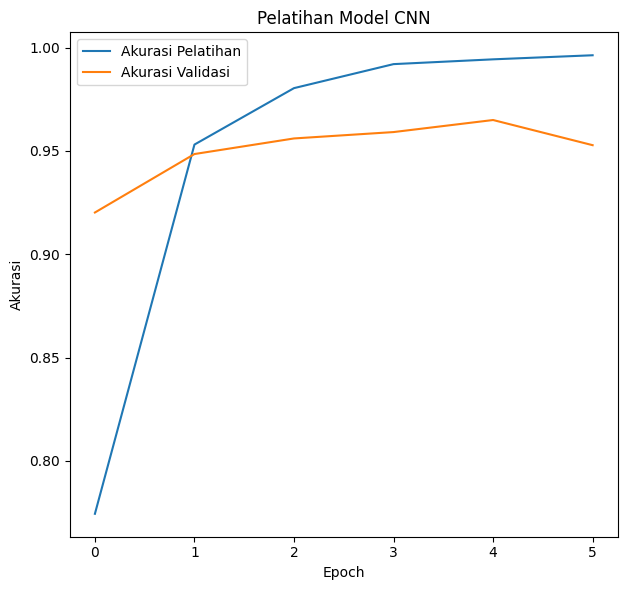

In [15]:
plt.figure(figsize=(12, 6))
# Plot akurasi pelatihan dan validasi untuk model CNN
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Akurasi Pelatihan')
plt.plot(history.history['val_accuracy'], label='Akurasi Validasi')
plt.title('Pelatihan Model CNN')
plt.xlabel('Epoch')
plt.ylabel('Akurasi')
plt.legend()

# Menyesuaikan tata letak plot dan menampilkan plot
plt.tight_layout()
plt.show()


# Memprediksi Kalimat

untuk memulainya, perlu memasukan jumlah kalimat yang ingin diprediksi. selanjutnya masukan kalimat tersebut.

In [56]:
from cleaning import preprocessing_text
import numpy as np

# Ambil teks baru dari pengguna
new_texts = []
num_texts = int(input("Masukkan jumlah teks yang ingin diprediksi: "))

for i in range(num_texts):
    text = input(f"Masukkan teks ke-{i+1}: ")
    new_texts.append(text)

predictions = []

# Proses prediksi untuk setiap teks baru
for new_text in new_texts:
    cleaned_text = preprocessing_text(new_text)

    # Tokenisasi dan padding teks baru
    sequences = tokenizer.texts_to_sequences([cleaned_text])
    padded_sequences = pad_sequences(sequences, maxlen=max_len, padding='post')

    # Prediksi menggunakan model CNN
    cnn_prediction = model_cnn.predict(padded_sequences)
    predicted_label = np.argmax(cnn_prediction, axis=1)
    
    predictions.append(predicted_label)

# Tampilkan hasil prediksi
for i, prediction in enumerate(predictions):
    original_text = new_texts[i]
    pred_label = label_encoder.inverse_transform(prediction)
    print(f"Original Text {i+1}: {original_text}")
    print(f"Prediction: {pred_label[0]}")
    print()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Original Text 1: aplikasi buruk sekali
Prediction: negative

Original Text 2: cocok untuk nostalgia
Prediction: positive

Original Text 3: sangat bagus
Prediction: neutral



In [16]:
import pickle

# Simpan model menggunakan pickle
cnn_model_path = 'model_cnn.pkl'
with open(cnn_model_path, 'wb') as file:
    pickle.dump(model_cnn, file)

print(f"Model CNN disimpan dalam {cnn_model_path}")

# Muat model menggunakan pickle
with open(cnn_model_path, 'rb') as file:
    loaded_model_cnn = pickle.load(file)

print("Model CNN berhasil dimuat kembali")

# Evaluasi model yang dimuat
loaded_results = loaded_model_cnn.evaluate(X_test_pad, y_test_encoded)
print(loaded_results)


Model CNN disimpan dalam model_cnn.pkl
Model CNN berhasil dimuat kembali
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9571 - loss: 0.1290
[0.13125361502170563, 0.9560741186141968]
